In [1]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Given molalities in mol/kg
molalities = np.array([0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.23])

In [3]:
pKa_NH4   = 9.25
pKa_H2PO4 = 7.20

In [4]:
# Equilibrium constants at 25°C ka values from pka = -log(ka)
Ka_NH4 = 10**-pKa_NH4  # NH4+ <=> NH3 + H+ 
Ka1_H3PO4 = 10**-2.1  # H3PO4 <=> H2PO4- + H+
Ka2_H2PO4 = 10**-pKa_H2PO4  # H2PO4- <=> HPO4^2- + H+
Ka3_HPO4 = 10**-12.3  # HPO4^2- <=> PO4^3- + H+ 
Kw = 10**-14 # Water ionization constant

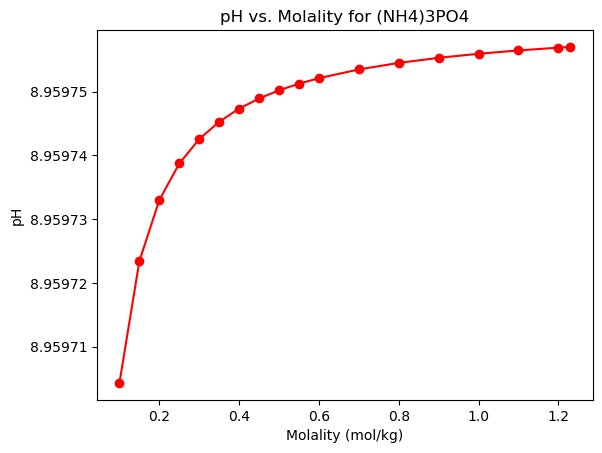

In [5]:
def pH_NH4PO4(molality_list, initial_guess=7.0):
    """
    Solve for the pH of (NH4)3PO4 solutions for given molality (m).
    """

    def charge_balance(pH_array, m):
        """
        Function to obtain charge balance equation residual: cations - anions
        """
        pH = pH_array[0]
        H_conc = 10.0**(-pH)
        if H_conc <= 0:
            return [1e10]

        OH_conc = Kw / H_conc
        
        # total ammonia = 3*m because (NH4)3PO4 has 3 NH4+ per PO4
        NH4_conc = (3.0*m) / (1.0 + (Ka_NH4 / H_conc))
        NH3_conc = NH4_conc * (Ka_NH4 / H_conc)

        # total phosphate = m. [H2PO4-] equilibrium equation will be the total phosphate concentration/denom
        denom = (
            1.0
            + (H_conc / Ka1_H3PO4)
            + (Ka2_H2PO4 / H_conc)
            + ((Ka2_H2PO4 * Ka3_HPO4) / (H_conc * H_conc))
        )
        H2PO4_conc = m / denom
        HPO4_conc = H2PO4_conc * (Ka2_H2PO4 / H_conc)
        PO4_conc = H2PO4_conc * ((Ka2_H2PO4*Ka3_HPO4)/(H_conc*H_conc))

        # cations - anions
        diff = (H_conc + NH4_conc) - (OH_conc + H2PO4_conc + 2.0*HPO4_conc + 3.0*PO4_conc)
        return [diff]

    results = []

    for m in molality_list:
        # Solve for pH by finding root with fsolve
        sol = fsolve(charge_balance, [initial_guess], args=(m,))
        pH = sol[0]

        #Recalculate concentrations of components for checks
        H_conc = 10.0**(-pH)
        OH_conc = Kw / H_conc

        NH4_conc = (3.0*m) / (1.0 + (Ka_NH4 / H_conc))
        NH3_conc = NH4_conc * (Ka_NH4 / H_conc)

        denom = (
            1.0
            + (H_conc / Ka1_H3PO4)
            + (Ka2_H2PO4 / H_conc)
            + ((Ka2_H2PO4 * Ka3_HPO4) / (H_conc * H_conc))
        )
        H2PO4_conc = m / denom
        HPO4_conc = H2PO4_conc * (Ka2_H2PO4 / H_conc)
        PO4_conc = H2PO4_conc * ((Ka2_H2PO4*Ka3_HPO4)/(H_conc*H_conc))
        H3PO4_conc = H2PO4_conc * (H_conc / Ka1_H3PO4)

        # Check with Henderson-Hasselbalch
        # NH4+ / NH3
        # pH ~ pKa_NH4 + log10([NH3]/[NH4+])
        if NH4_conc > 0:
            pH_HH_NH4 = pKa_NH4 + np.log10(NH3_conc / NH4_conc)
        else:
            pH_HH_NH4 = np.nan

        # H2PO4- / HPO4^2- (pKa2 ~ 7.20)
        # pH ~ pKa2 + log10([HPO4^2-]/[H2PO4-])
        if H2PO4_conc > 0:
            pH_HH_phosphate = pKa_H2PO4 + np.log10(HPO4_conc / H2PO4_conc)
        else:
            pH_HH_phosphate = np.nan

        # Charge balance check should result close to 0
        residual = charge_balance([pH], m)[0]

        # Mass balance checks
        phosphate_sum = H3PO4_conc + H2PO4_conc + HPO4_conc + PO4_conc
        ammonia_sum = NH4_conc + NH3_conc  # should be ~ 3*m
    
        results.append({
            "Molality": m,
            "pH": pH,
            "pH_HH_NH4/NH3": pH_HH_NH4,
            "pH_HH_H2PO4/HPO4": pH_HH_phosphate,
            "ChargeBalanceResidual": residual,
            "PhosphateSum": phosphate_sum,
            "AmmoniaSum": ammonia_sum,
            "[H+]": H_conc,
            "[OH-]": OH_conc,
            "[NH4+]": NH4_conc,
            "[NH3]": NH3_conc,
            "[H3PO4]": H3PO4_conc,
            "[H2PO4-]": H2PO4_conc,
            "[HPO4^2-]": HPO4_conc,
            "[PO4^3-]": PO4_conc
        })

    return pd.DataFrame(results)

df_NH4PO4 = pH_NH4PO4(molalities, initial_guess=7.0)

# Plot NH4PO4
plt.figure()
plt.plot(df_NH4PO4["Molality"], df_NH4PO4["pH"], marker='o', color='red')
plt.xlabel("Molality (mol/kg)")
plt.ylabel("pH")
plt.title("pH vs. Molality for (NH4)3PO4")
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()

In [6]:
df_NH4PO4

,Molality,pH,pH_HH_NH4/NH3,pH_HH_H2PO4/HPO4,ChargeBalanceResidual,PhosphateSum,AmmoniaSum,[H+],[OH-],[NH4+],[NH3],[H3PO4],[H2PO4-],[HPO4^2-],[PO4^3-]
0,0.10,8.959704,8.959704,8.959704,1.665335e-16,0.10,0.30,1.097225e-09,0.000009,0.198345,0.101655,2.359984e-10,0.001708,0.098247,0.000045
1,0.15,8.959723,8.959723,8.959723,1.110223e-16,0.15,0.45,1.097177e-09,0.000009,0.297514,0.152486,3.539667e-10,0.002563,0.147370,0.000067
2,0.20,8.959733,8.959733,8.959733,1.665335e-16,0.20,0.60,1.097153e-09,0.000009,0.396682,0.203318,4.719350e-10,0.003417,0.196493,0.000090
3,0.25,8.959739,8.959739,8.959739,-2.220446e-16,0.25,0.75,1.097138e-09,0.000009,0.495850,0.254150,5.899032e-10,0.004271,0.245617,0.000112
4,0.30,8.959743,8.959743,8.959743,-2.220446e-16,0.30,0.90,1.097128e-09,0.000009,0.595019,0.304981,7.078715e-10,0.005125,0.294740,0.000135
5,0.35,8.959745,8.959745,8.959745,-3.330669e-16,0.35,1.05,1.097121e-09,0.000009,0.694187,0.355813,8.258398e-10,0.005979,0.343864,0.000157
6,0.40,8.959747,8.959747,8.959747,0.000000e+00,0.40,1.20,1.097116e-09,0.000009,0.793355,0.406645,9.438081e-10,0.006833,0.392987,0.000180
7,0.45,8.959749,8.959749,8.959749,-6.661338e-16,0.45,1.35,1.097112e-09,0.000009,0.892524,0.457476,1.061776e-09,0.007687,0.442111,0.000202
8,0.50,8.959750,8.959750,8.959750,-5.551115e-16,0.50,1.50,1.097109e-09,0.000009,0.991692,0.508308,1.179745e-09,0.008542,0.491234,0.000224
9,0.55,8.959751,8.959751,8.959751,8.881784e-16,0.55,1.65,1.097106e-09,0.000009,1.090860,0.559140,1.297713e-09,0.009396,0.540357,0.000247


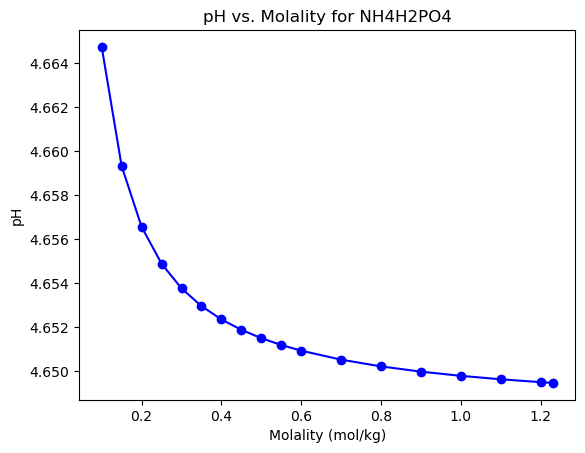

In [7]:
def pH_NH4H2PO4(molality_list, initial_guess=7.0):
    """
    Solve for the pH of NH4H2PO4 solutions for given molality (m).
    """

    def charge_balance(pH_array, m):
        """
        Function to obtain charge balance equation residual: cations - anions
        """
        pH = pH_array[0]
        H_conc = 10.0**(-pH)
        if H_conc <= 0:
            return [1e10]

        OH_conc = Kw / H_conc
        

        NH4_conc = m / (1.0 + (Ka_NH4 / H_conc))
        NH3_conc = NH4_conc * (Ka_NH4 / H_conc)

        # total phosphate = m. [H2PO4-] equilibrium equation will be the total phosphate concentration/denom
        denom = (
            1.0
            + (H_conc / Ka1_H3PO4)
            + (Ka2_H2PO4 / H_conc)
            + ((Ka2_H2PO4 * Ka3_HPO4) / (H_conc * H_conc))
        )
        H2PO4_conc = m / denom
        HPO4_conc = H2PO4_conc * (Ka2_H2PO4 / H_conc)
        PO4_conc = H2PO4_conc * ((Ka2_H2PO4*Ka3_HPO4)/(H_conc*H_conc))

        # cations - anions
        diff = (H_conc + NH4_conc) - (OH_conc + H2PO4_conc + 2.0*HPO4_conc + 3.0*PO4_conc)
        return [diff]

    results = []

    for m in molality_list:
        # Solve for pH by finding root with fsolve
        sol = fsolve(charge_balance, [initial_guess], args=(m,))
        pH = sol[0]

        #Recalculate concentrations of components for checks
        H_conc = 10.0**(-pH)
        OH_conc = Kw / H_conc

        NH4_conc = m / (1.0 + (Ka_NH4 / H_conc))
        NH3_conc = NH4_conc * (Ka_NH4 / H_conc)

        denom = (
            1.0
            + (H_conc / Ka1_H3PO4)
            + (Ka2_H2PO4 / H_conc)
            + ((Ka2_H2PO4 * Ka3_HPO4) / (H_conc * H_conc))
        )
        H2PO4_conc = m / denom
        HPO4_conc = H2PO4_conc * (Ka2_H2PO4 / H_conc)
        PO4_conc = H2PO4_conc * ((Ka2_H2PO4*Ka3_HPO4)/(H_conc*H_conc))
        H3PO4_conc = H2PO4_conc * (H_conc / Ka1_H3PO4)

        # Check with Henderson-Hasselbalch
        # NH4+ / NH3
        # pH ~ pKa_NH4 + log10([NH3]/[NH4+])
        if NH4_conc > 0:
            pH_HH_NH4 = pKa_NH4 + np.log10(NH3_conc / NH4_conc)
        else:
            pH_HH_NH4 = np.nan

        # H2PO4- / HPO4^2- (pKa2 ~ 7.20)
        # pH ~ pKa2 + log10([HPO4^2-]/[H2PO4-])
        if H2PO4_conc > 0:
            pH_HH_phosphate = pKa_H2PO4 + np.log10(HPO4_conc / H2PO4_conc)
        else:
            pH_HH_phosphate = np.nan

        # Charge balance check should result close to 0
        residual = charge_balance([pH], m)[0]

        # Mass balance checks
        phosphate_sum = H3PO4_conc + H2PO4_conc + HPO4_conc + PO4_conc
        ammonia_sum = NH4_conc + NH3_conc 

        results.append({
            "Molality": m,
            "pH": pH,
            "pH_HH_NH4/NH3": pH_HH_NH4,
            "pH_HH_H2PO4/HPO4": pH_HH_phosphate,
            "ChargeBalanceResidual": residual,
            "PhosphateSum": phosphate_sum,
            "AmmoniaSum": ammonia_sum,
            "[H+]": H_conc,
            "[OH-]": OH_conc,
            "[NH4+]": NH4_conc,
            "[NH3]": NH3_conc,
            "[H3PO4]": H3PO4_conc,
            "[H2PO4-]": H2PO4_conc,
            "[HPO4^2-]": HPO4_conc,
            "[PO4^3-]": PO4_conc
        })

    return pd.DataFrame(results)

df_NH4H2PO4 = pH_NH4H2PO4(molalities, initial_guess=7.0)

# Plot NH4H2PO4
plt.figure()
plt.plot(df_NH4H2PO4["Molality"], df_NH4H2PO4["pH"], marker='o', color='blue')
plt.xlabel("Molality (mol/kg)")
plt.ylabel("pH")
plt.title("pH vs. Molality for NH4H2PO4")
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()

In [8]:
df_NH4H2PO4

,Molality,pH,pH_HH_NH4/NH3,pH_HH_H2PO4/HPO4,ChargeBalanceResidual,PhosphateSum,AmmoniaSum,[H+],[OH-],[NH4+],[NH3],[H3PO4],[H2PO4-],[HPO4^2-],[PO4^3-]
0,0.10,4.664750,4.664750,4.664750,0.000000e+00,0.10,0.10,0.000022,4.621150e-10,0.099997,0.000003,0.000271,0.099439,0.000290,6.715178e-12
1,0.15,4.659329,4.659329,4.659329,-2.775558e-17,0.15,0.15,0.000022,4.563823e-10,0.149996,0.000004,0.000411,0.149159,0.000430,9.824423e-12
2,0.20,4.656567,4.656567,4.656567,2.775558e-17,0.20,0.20,0.000022,4.534887e-10,0.199995,0.000005,0.000552,0.198879,0.000569,1.293366e-11
3,0.25,4.654892,4.654892,4.654892,-1.110223e-16,0.25,0.25,0.000022,4.517437e-10,0.249994,0.000006,0.000693,0.248599,0.000709,1.604290e-11
4,0.30,4.653769,4.653769,4.653769,-1.110223e-16,0.30,0.30,0.000022,4.505766e-10,0.299992,0.000008,0.000834,0.298318,0.000848,1.915214e-11
5,0.35,4.652963,4.652963,4.652963,0.000000e+00,0.35,0.35,0.000022,4.497411e-10,0.349991,0.000009,0.000974,0.348038,0.000988,2.226138e-11
6,0.40,4.652356,4.652356,4.652356,-1.110223e-16,0.40,0.40,0.000022,4.491135e-10,0.399990,0.000010,0.001115,0.397758,0.001127,2.537062e-11
7,0.45,4.651883,4.651883,4.651883,0.000000e+00,0.45,0.45,0.000022,4.486247e-10,0.449989,0.000011,0.001256,0.447478,0.001267,2.847986e-11
8,0.50,4.651504,4.651504,4.651504,1.110223e-16,0.50,0.50,0.000022,4.482333e-10,0.499987,0.000013,0.001396,0.497197,0.001406,3.158909e-11
9,0.55,4.651194,4.651194,4.651194,0.000000e+00,0.55,0.55,0.000022,4.479128e-10,0.549986,0.000014,0.001537,0.546917,0.001546,3.469833e-11


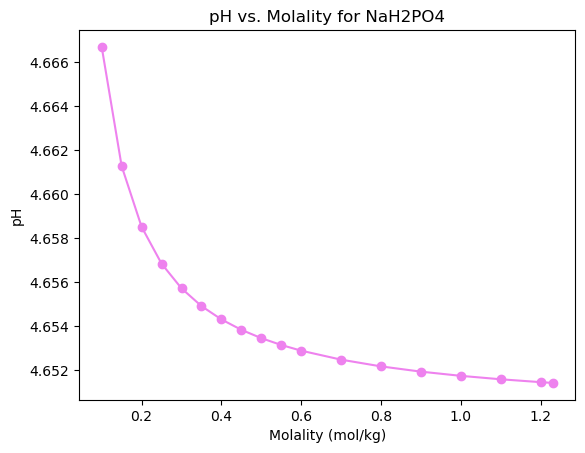

In [9]:
def pH_NaH2PO4(molality_list, initial_guess=7.0):
    """
    Solve for the pH of NaH2PO4 solutions for given molality (m).
    """

    def charge_balance(pH_array, m):
        """
        Function to obtain charge balance equation residual: cations - anions
        """
        pH = pH_array[0]
        H_conc = 10.0**(-pH)
        if H_conc <= 0:
            return [1e10]

        OH_conc = Kw / H_conc
        
        Na_conc = m

        # total phosphate = m. [H2PO4-] equilibrium equation will be the total phosphate concentration/denom
        denom = (
            1.0
            + (H_conc / Ka1_H3PO4)
            + (Ka2_H2PO4 / H_conc)
            + ((Ka2_H2PO4 * Ka3_HPO4) / (H_conc * H_conc))
        )
        H2PO4_conc = m / denom
        HPO4_conc = H2PO4_conc * (Ka2_H2PO4 / H_conc)
        PO4_conc = H2PO4_conc * ((Ka2_H2PO4*Ka3_HPO4)/(H_conc*H_conc))

        # cations - anions
        diff = (H_conc + Na_conc) - (OH_conc + 3 * PO4_conc + 2 * HPO4_conc + H2PO4_conc)
        return [diff]

    results = []

    for m in molality_list:
        # Solve for pH by finding root with fsolve
        sol = fsolve(charge_balance, [initial_guess], args=(m,))
        pH = sol[0]

        #Recalculate concentrations of components for checks
        H_conc = 10.0**(-pH)
        OH_conc = Kw / H_conc

        Na_conc = m

        denom = (
            1.0
            + (H_conc / Ka1_H3PO4)
            + (Ka2_H2PO4 / H_conc)
            + ((Ka2_H2PO4 * Ka3_HPO4) / (H_conc * H_conc))
        )
        H2PO4_conc = m / denom
        HPO4_conc = H2PO4_conc * (Ka2_H2PO4 / H_conc)
        PO4_conc = H2PO4_conc * ((Ka2_H2PO4*Ka3_HPO4)/(H_conc*H_conc))
        H3PO4_conc = H2PO4_conc * (H_conc / Ka1_H3PO4)

        # Check with Henderson-Hasselbalch
        # H2PO4- / HPO4^2- (pKa2 ~ 7.20)
        # pH ~ pKa2 + log10([HPO4^2-]/[H2PO4-])
        if H2PO4_conc > 0:
            pH_HH_phosphate = pKa_H2PO4 + np.log10(HPO4_conc / H2PO4_conc)
        else:
            pH_HH_phosphate = np.nan

        # Charge balance check should result close to 0
        residual = charge_balance([pH], m)[0]

        # Mass balance checks
        phosphate_sum = H3PO4_conc + H2PO4_conc + HPO4_conc + PO4_conc
        sodium_sum = Na_conc 

        results.append({
            "Molality": m,
            "pH": pH,
            "pH_HH_H2PO4/HPO4": pH_HH_phosphate,
            "ChargeBalanceResidual": residual,
            "PhosphateSum": phosphate_sum,
            "SodiumSum": sodium_sum,
            "[H+]": H_conc,
            "[OH-]": OH_conc,
            "[Na+]": Na_conc,
            "[H3PO4]": H3PO4_conc,
            "[H2PO4-]": H2PO4_conc,
            "[HPO4^2-]": HPO4_conc,
            "[PO4^3-]": PO4_conc
        })

    return pd.DataFrame(results)

df_NaH2PO4 = pH_NaH2PO4(molalities, initial_guess=7.0)

# Plot NaH2PO4
plt.figure()
plt.plot(df_NaH2PO4["Molality"], df_NaH2PO4["pH"], marker='o', color='violet')
plt.xlabel("Molality (mol/kg)")
plt.ylabel("pH")
plt.title("pH vs. Molality for NaH2PO4")
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()


In [10]:
df_NaH2PO4

,Molality,pH,pH_HH_H2PO4/HPO4,ChargeBalanceResidual,PhosphateSum,SodiumSum,[H+],[OH-],[Na+],[H3PO4],[H2PO4-],[HPO4^2-],[PO4^3-]
0,0.10,4.666688,4.666688,1.387779e-17,0.10,0.10,0.000022,4.641812e-10,0.10,0.000270,0.099439,0.000291,6.775357e-12
1,0.15,4.661266,4.661266,2.775558e-17,0.15,0.15,0.000022,4.584229e-10,0.15,0.000410,0.149159,0.000431,9.912469e-12
2,0.20,4.658504,4.658504,2.775558e-17,0.20,0.20,0.000022,4.555164e-10,0.20,0.000550,0.198879,0.000572,1.304958e-11
3,0.25,4.656830,4.656830,-5.551115e-17,0.25,0.25,0.000022,4.537636e-10,0.25,0.000690,0.248599,0.000712,1.618668e-11
4,0.30,4.655706,4.655706,0.000000e+00,0.30,0.30,0.000022,4.525913e-10,0.30,0.000830,0.298318,0.000852,1.932379e-11
5,0.35,4.654900,4.654900,5.551115e-17,0.35,0.35,0.000022,4.517521e-10,0.35,0.000970,0.348038,0.000992,2.246089e-11
6,0.40,4.654294,4.654294,0.000000e+00,0.40,0.40,0.000022,4.511216e-10,0.40,0.001110,0.397758,0.001132,2.559800e-11
7,0.45,4.653821,4.653821,0.000000e+00,0.45,0.45,0.000022,4.506307e-10,0.45,0.001250,0.447478,0.001272,2.873510e-11
8,0.50,4.653442,4.653442,0.000000e+00,0.50,0.50,0.000022,4.502375e-10,0.50,0.001390,0.497197,0.001412,3.187221e-11
9,0.55,4.653131,4.653131,1.110223e-16,0.55,0.55,0.000022,4.499156e-10,0.55,0.001530,0.546917,0.001553,3.500931e-11
